### Useful Resources

- [A Practical Guide to LambdaMART in LightGbm](https://medium.datadriveninvestor.com/a-practical-guide-to-lambdamart-in-lightgbm-f16a57864f6)
- [lightgbm.LGBMRanker Documentation](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRanker.html#)
- [LightGBM Parameter Tuning Guide](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
- [How To Use Optuna to Tune LightGBM Hyperparameters](https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/)
- [Optuna](https://optuna.readthedocs.io/en/stable/tutorial/index.html)

### Global Constants

In [1]:
# --------------- Model --------------- #
# k for NDCG@k
K = 50    
# Number of iterations/trees for LightGBM              
NUM_ITERATIONS = 10 # 1000

# --------------- Tuning --------------- #
# number of trials for Optuna
N_TRIALS = 5   # 30   

### Libraries

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import pickle

import psutil
import os
from pathlib import Path
from datetime import datetime
import json

from data import read_processed_train, read_processed_val, read_processed_test

/Users/nathanjones/Development/VU/DMT/dmt_recom_sys/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Data

In [3]:
train_df = read_processed_train()
val_df = read_processed_val()
test_df = read_processed_test()

### Change Target

**Function Definitions**
- Take in train_df or val_df and modify the target column
- All columns can be used
- Do not change the row order
- **target must be an integer**

In [4]:
def base_target(df):
    """
    Applies the weighting given in the assignment (no discounting)
    """
    df['target'] = 0

    mask = df['click_bool'] == 1
    df.loc[mask, 'target'] = 1

    mask = df['booking_bool'] == 1
    df.loc[mask, 'target'] = 5

    return df

In [ ]:
# Add others...

**Apply Functions**

- Apply one of the above functions to train_df and val_df

In [5]:
# Choice of target function
target_func = base_target

# ---------------------------------- #

# Apply target function
train_df = target_func(train_df)
val_df = target_func(val_df)

### Feature Engineering

**Function Defintions**
- Take in a dataframe and modify/add columns
- Must be applicable to train_df, val_df and test_df
- Do not change the row order

In [6]:
def hour_day_month_year(df):
    """
    Function to create day, month, year columns from date_time column.
    """
    df['date_time'] = pd.to_datetime(df['date_time'])

    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['year'] = df['date_time'].dt.year

    return df

In [ ]:
# Add others...

**Apply Functions**

- Apply some combination of the above functions to train_df, val_df and test_df

In [7]:
# List of functions to apply in order
feature_functions = [hour_day_month_year]

# ---------------------------------- #

# Apply listed functions
for func in feature_functions:
    train_df = func(train_df)
    val_df = func(val_df)
    test_df = func(test_df)

### Final Data Preparation

Removing unwanted columns and preparing the data for the model

In [8]:
# Specify additional columns to remove
add_drop_cols = ['srch_id', 'date_time', 'prop_id']

# ---------------------------------- #

# Remove columns that won't be used as features
# TODO: add 'gross_booking_usd' to the list once it is added to the dataset
train_only_cols = ['position', 'click_bool', 'booking_bool', 'target'] + add_drop_cols

# Train data
group_train = train_df.groupby("srch_id")["srch_id"].count().to_numpy()
X_train = train_df.drop(columns=train_only_cols)
y_train = train_df['target'].astype(int)

# Validation data
group_val = val_df.groupby("srch_id")["srch_id"].count().to_numpy()
X_val = val_df.drop(columns=train_only_cols)
y_val = val_df['target'].astype(int)

# Test data
X_test = test_df.drop(columns=add_drop_cols).to_numpy(copy=True)

### Tuning

In [9]:
# Create the folder to store the results of the tuning
tune_folder_path = Path("./tuned_models/" + datetime.now().strftime("%Y%m%d_%H%M%S"))
tune_folder_path.mkdir(parents=True, exist_ok=True)

Constant hyperparameters

In [10]:
const_params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "ndcg",
    "n_estimators": NUM_ITERATIONS, 
    "importance_type": "gain",
    "label_gain": [i for i in range(max(y_train.max(), y_val.max()) + 1)],
    "bagging_freq": 1,
    "n_jobs": psutil.cpu_count(logical=False),
    "verbosity": -1
    }

Define the objective

In [11]:
def objective(trial):
    tuned_params = {
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        'max_depth': trial.suggest_int('max_depth', -1, 500, 50), # TODO: move to constant = -1?
        "learning_rate": trial.suggest_float("learning_rate", 5e-4, 0.01, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    params = const_params | tuned_params

    model = lgb.LGBMRanker(**params)
    model.fit(
        X=X_train,
        y=y_train,
        group=group_train,
        eval_set=[(X_train, y_train),(X_val, y_val)],
        eval_group=[group_train, group_val],
        eval_at=[K], # k for NDCG@k
        verbose=False,
      )
    
    # Save the trained model
    with open(tune_folder_path / f"trial_{trial.number}.pkl", "wb") as f:
        pickle.dump(model, f)

    best_val_score = model.best_score_['valid_1'][f'ndcg@{K}']
    return best_val_score

Optimise the objective

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2023-05-23 00:05:13,330] A new study created in memory with name: no-name-24a701dc-768a-4b48-ad9b-056cc024243d
/Users/nathanjones/Development/VU/DMT/dmt_recom_sys/venv/lib/python3.10/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
/Users/nathanjones/Development/VU/DMT/dmt_recom_sys/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-23 00:05:37,055] Trial 0 finished with value: 0.4073069954428158 and parameters: {'num_leaves': 899, 'max_depth': 299, 'learning_rate': 0.0042814337104550276, 'subsample': 0.672093584711961, 'colsample_bytree': 0.08428232385361006, 'min_data_in_leaf': 89}. Best is trial 0 with value: 0.4073069954428158.
/Users/nathanjones/Development/VU/DMT/dmt_recom_sys/venv/lib/python3.10/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(
/Users/nathanjones/Development/VU/DMT/dmt_recom_sys/venv/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-23 00:05:59,562

Save the results

In [13]:
# Keep only the best model (and rename it)
for trial in study.trials:
    if trial.number != study.best_trial.number:
        os.remove(tune_folder_path / f"trial_{trial.number}.pkl")
    else:
        os.rename(tune_folder_path / f"trial_{trial.number}.pkl", tune_folder_path / "best_model.pkl")

In [14]:
# Save the best hyperparameters
with open(tune_folder_path / "best_params.json", "w") as f:
    best_params = const_params | study.best_params
    json.dump(best_params, f)

# Save some other relevant information
with open(tune_folder_path / "info.txt", "w") as f:
    f.write(f"{10 * '-'} Global constants {10 * '-'}\n\n")
    f.write(f"NUM_ITERATIONS = {NUM_ITERATIONS}\n")
    f.write(f"K = {K}\n")
    f.write(f"N_TRIALS = {N_TRIALS}\n\n")
    f.write(f"{10 * '-'} Features {10 * '-'}\n\n")
    f.write(f"{list(X_train.columns)}\n\n")
    f.write(f"{10 * '-'} Study Info {10 * '-'}\n\n")
    f.write(f"Best value: {study.best_value}\n")
    f.write(f"Best trial number: {study.best_trial.number}\n")

### Training

**Load the model (choose one)**

1. Create a new model with hand-picked hyperparameters

In [ ]:
params = {
        # Constant parameters
        "objective": "lambdarank",
        "boosting_type": "gbdt",
        "metric": "ndcg",
        "n_estimators": NUM_ITERATIONS, 
        "importance_type": "gain",
        "label_gain": [i for i in range(max(y_train.max(), y_val.max()) + 1)],
        "bagging_freq": 1,
        "n_jobs": psutil.cpu_count(logical=False),
        "verbosity": -1,
        # Tuning parameters
        "num_leaves": 32,
        'max_depth': -1,
        "learning_rate": 0.01,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_data_in_leaf": 50,
    }

model = lgb.LGBMRanker(**params)

2. Create a new model with the most recently tuned hyperparamters

In [ ]:
root = Path("./tuned_models")
most_recent_dir = [str(d)[-15:] for d in sorted(root.iterdir()) if d.is_dir()][-1]

with open(root / most_recent_dir / "best_params.json", "r") as f:
    best_params = json.load(f)

model = lgb.LGBMRanker(**best_params)

3. Load the best model from the most recent tuning process

In [15]:
root = Path("./tuned_models")
most_recent_dir = [str(d)[-15:] for d in sorted(root.iterdir()) if d.is_dir()][-1]
model_path = root / most_recent_dir / "best_model.pkl"

model = pickle.load(open(model_path, "rb"))

4. Custom

In [ ]:
# Create a lgb.LGBMRanker model however you like
# model = ...

**Fitting the model** (skip if using a trained model)

In [ ]:
model.fit(
      X=X_train,
      y=y_train,
      group=group_train,
      eval_set=[(X_train, y_train),(X_val, y_val)],
      eval_group=[group_train, group_val],
      eval_at=[K] # k for NDCG@k
      )

### Plots

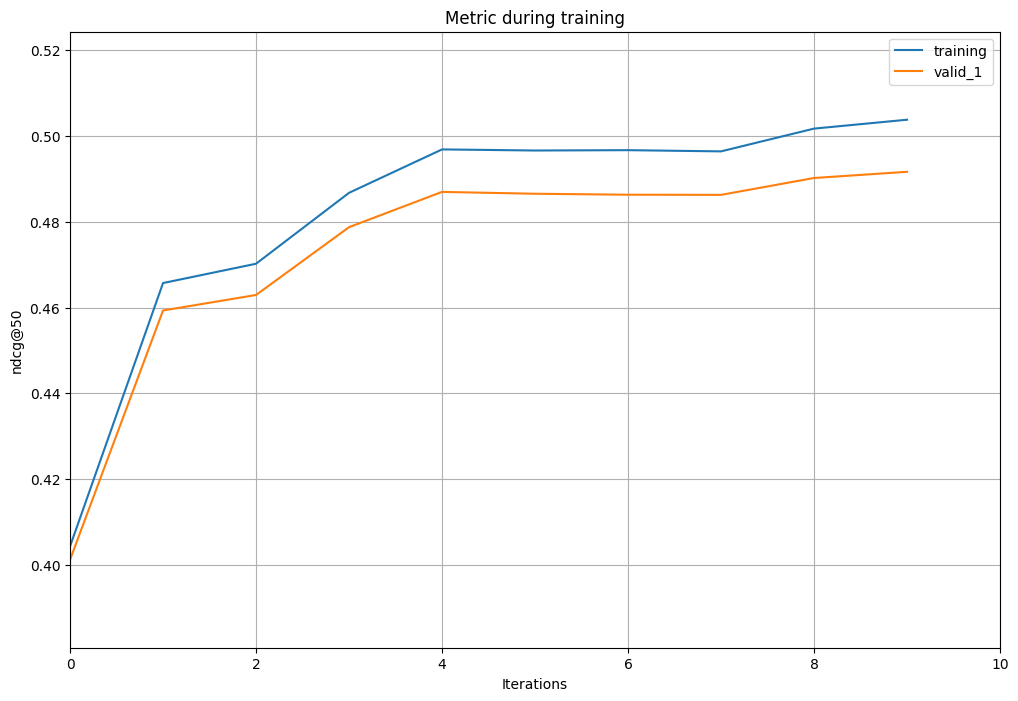

In [16]:
ax_metric = lgb.plot_metric(model, figsize = (12,8))

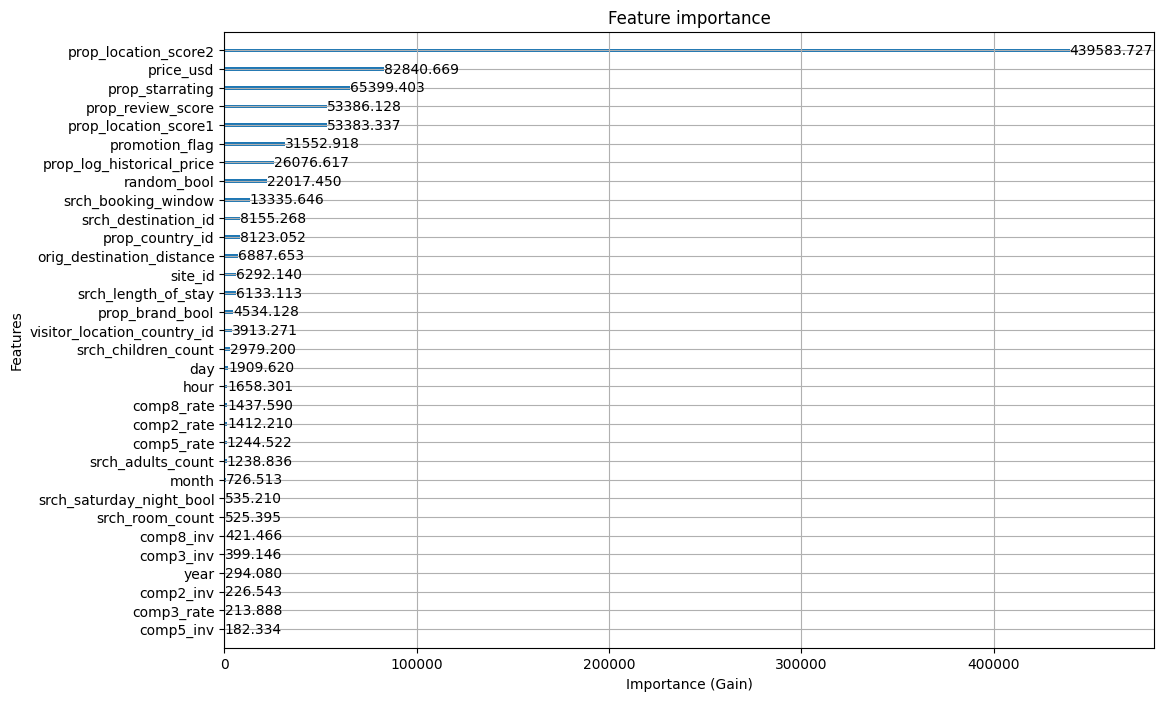

In [17]:
ax_importance = lgb.plot_importance(model, xlabel='Importance (Gain)', figsize = (12,8))

### Testing

In [ ]:
prediction = model.predict(X_test)
test_df['prediction'] = prediction
test_df = test_df.sort_values(by=['srch_id', 'prediction'], ascending=[True, False])

### Save Results

In [ ]:
# Create the folder to store the results of the training
train_folder_path = Path("./trained_models/" + datetime.now().strftime("%Y%m%d_%H%M%S"))
train_folder_path.mkdir(parents=True, exist_ok=True)

# Save the model
pickle.dump(model, open(train_folder_path / "model.pkl", "wb"))

# Save the parameters
with open(train_folder_path / "params.txt", "w") as f:
    f.write(json.dumps(model.get_params()))

# Save the feature names
with open(train_folder_path / "feature_names.txt", "w") as f:
    f.write(str(list(X_train.columns)))

# Save the figures
ax_metric.figure.savefig(train_folder_path / "learning_curve.pdf", bbox_inches="tight")
ax_importance.figure.savefig(train_folder_path / "feature_importance.pdf", bbox_inches="tight")

# Save best evaluation scores
with open(train_folder_path / "best_scores.txt", "w") as f:
    f.write("Best training score: " + str(model.best_score_['training'][f'ndcg@{K}']) + "\n")
    f.write("Best validation score: " + str(model.best_score_['valid_1'][f'ndcg@{K}']) + "\n")

# Save the submission file
submission_file = train_folder_path / "submission.csv"
test_df[['srch_id', 'prop_id']].to_csv(submission_file, index=False)

### Playground

In [ ]:
x = {"a": 1, "b": 2}
y = {"c": 3, "d": 4}

x | y